In [39]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict
import matplotlib.pyplot as plt

color = "#507bbf"
plt.style.use("bmh")

## Data Processing

In [40]:
features_dict = {
    "stfmjob":  "How satisfied are you in your main job",
    "trdawrk":  "Too tired after work to enjoy things like doing at home, how often",
    "jbprtfp":  "Job prevents you from giving time to partner/family, how often",
    "pfmfdjba": "Partner/family fed up with pressure of your job, how often",
    "dcsfwrka": "Current job: can decide time start/finish work",
    "wrkhome":  "Work from home or place of choice, how often",
    "wrklong":  "Employees expected to work overtime, how often",
    "wrkresp":  "Employees expected to be responsive outside working hours, how often",
    "health":   "Subjective general health",
    "stfeco":   "How satisfied with present state of economy in country",
    "hhmmb":    "Number of people living regularly as member of household",
    "hincfel":  "Feeling about household's income nowadays",
    "trstplc":  "Trust in the police",
    "sclmeet":  "How often socially meet with friends, relatives or colleagues",
    "hlthhmp":  "Hampered in daily activities by illness/disability/infirmity/mental problem",
    "sclact":   "Take part in social activities compared to others of same age",
    "iphlppl":  "Important to help people and care for others well-being",
    "ipsuces":  "Important to be successful and that people recognise achievements",
    "ipstrgv":  "Important that government is strong and ensures safety",
    "gndr"   :  "Gender",
    "cntry"  :  "Country",
    "happy":    "Happiness"
}

In [41]:
data = pd.read_csv(
    "/home/mehrshad/code/arthurcornelio88/how-happy"
    +"-in-europe/data/20240319_ESS10_manually-filtered_arthurcornelio88.csv"
).reset_index(drop=True)
data = data.drop("Unnamed: 0", axis=1)
data = data[~data["happy"].isin([77, 88, 99])]

with open("../data/features_table.json", 'r') as file:
    features_tables = json.load(file)

/tmp/ipykernel_17957/66283325.py:1: DtypeWarning: Columns (82,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(


In [42]:
def json_to_df(features_json: Dict, feature: str) -> pd.DataFrame:
    """
    Converts a specified feature from a JSON object into a pandas DataFrame. The function expects the feature to be
    represented as a dictionary within the JSON object, where each key-value pair corresponds to an entity's identifier
    and its description, respectively. It creates a DataFrame with two columns: one for the identifiers (appending '_key'
    to the feature name) and one for the descriptions (appending '_desc' to the feature name), ensuring that identifiers
    are of integer type and descriptions are of string type.

    Parameters:
    -----------
    df : pd.DataFrame
        The original DataFrame to be enriched.
    enrichment_df : pd.DataFrame
        The DataFrame containing additional information for the enrichment, with columns named 'feature_key' and 'feature_desc'.

    Returns:
    -------
    pd.DataFrame
        The enriched DataFrame with additional descriptive information merged on the specified feature.
    """
    feature_dict = features_json[feature]
    df = pd.DataFrame.from_dict(
        feature_dict,
        columns=["val"],
        orient="index").reset_index()
    df.columns = [feature+"_key", feature+"_desc"]
    df[feature+"_key"] = df[feature+"_key"].astype(int)
    df[feature+"_desc"] = df[feature+"_desc"].astype(str)
    return df

def enrich_df(df: pd.DataFrame, enrichment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Enriches a given DataFrame by merging it with another DataFrame that contains additional information for one of its
    features. The function automatically identifies the feature to be enriched based on the naming convention used in the
    'enrichment_df' (expects 'feature_key'). It performs a left merge on the specified feature, effectively adding the
    descriptive information from 'enrichment_df' into 'df' and dropping the redundant key column from the merge.

    Parameters:
    -----------
    df : pd.DataFrame
        The original DataFrame to be enriched.
    enrichment_df : pd.DataFrame
        The DataFrame containing additional information for the enrichment, with columns named 'feature_key' and 'feature_desc'.

    Returns:
    -------
    pd.DataFrame
        The enriched DataFrame with additional descriptive information merged on the specified feature.
    """
    feature = enrichment_df.columns[0].replace("_key", "")
    return df.merge(
        enrichment_df,
        how="left",
        left_on=feature,
        right_on=feature+"_key"
    ).drop(feature+"_key", axis=1)

def remove_star_vals(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Cleans the input DataFrame by removing rows where the description of a specified feature is marked with an asterisk ("*").
    It calculates and prints the percentage of rows being removed because of this placeholder value. This step is crucial for
    cleaning the dataset by eliminating entries with non-informative placeholder values, ensuring data quality for further
    analysis or modeling.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to be cleaned.
    feature : str
        The feature whose descriptions are to be examined for placeholder values.

    Returns:
    -------
    pd.DataFrame
        A DataFrame excluding rows with placeholder descriptions for the specified feature.
    """
    mask = df[feature+"_desc"] == "*"
    print(f"{feature} %rows: " + str(len(df[mask]) / len(df) * 100))
    return df[~mask]

In [43]:
def create_map(arr: np.ndarray) -> Dict:
    """
    Creates a mapping dictionary from an array of sorted unique integers.

    This function generates a symmetric mapping for the elements of the input array
    based on their order. If the length of the array is even, it creates a mapping
    such that the middle two elements map to -1 and 1, respectively, and other elements
    are symmetrically mapped outwards with increasing absolute values. For an odd-length
    array, the middle element is mapped to 1, and the remaining elements are symmetrically
    mapped with increasing absolute values starting from 2.

    The mapping is designed to transform the input array into a distribution centered
    around 1, which could be useful for normalization purposes where a balanced around
    one distribution is desired, such as in certain machine learning applications.

    Parameters:
    -----------
    arr : np.ndarray
        A numpy array of sorted unique integers. The array should not contain any gaps
        in integers and is expected to be sorted in ascending order.

    Returns:
    --------
    dict_map : Dict
        A dictionary where keys are the original integers from the input array and values
        are the integers mapped symmetrically around 1 as described above.

    Examples:
    ---------
    >>> create_map(np.array([1, 2, 3, 4, 5]))
    {-2: 1, -1: 2, 1: 3, 2: 4, 3: 5}

    >>> create_map(np.array([1, 2, 3, 4]))
    {-2: 1, -1: 2, 1: 3, 2: 4}

    """
    aux_vals = np.arange(1, arr[-1] // 2 + 1)
    if len(arr)%2 == 0:
        aux_vals = np.concatenate([-np.flip(aux_vals), aux_vals])
    else:
        aux_vals = np.concatenate([-np.flip(aux_vals) - 1, np.array([1]), aux_vals + 1])
    dict_map = {}
    for ind, el in enumerate(arr):
        dict_map[el] = aux_vals[ind]
    return dict_map

In [44]:
# this dict map is to reduce the happines
# categories into three general classes of
# unhappy, satisfied and happy
aux_data = data[features_dict.keys()].copy()

reduce_class_map = {
    0: 0, 1: 0, 2: 0, 3: 0,
    4: 1, 5: 1, 6: 1, 7: 1,
    8: 2, 9: 2, 10: 2
}

aux_data["happy_reduced"] = aux_data["happy"].replace(reduce_class_map)
aux_data = aux_data.reset_index(drop=True)

In [45]:
categorical_features_indices = [aux_data.columns.get_loc("cntry")]
categorical_features_indices

[20]

In [46]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
y_reduced = aux_data['happy_reduced']
cols = [col for col in aux_data.columns if "_desc" not in col and "happy" not in col]
X_res, y_res = smote_nc.fit_resample(aux_data[cols], aux_data["happy_reduced"])

In [47]:
aux_data = pd.concat([X_res, y_res], axis=1)

In [48]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False)
# cntry_encoded = encoder.fit_transform(aux_data[['cntry']])
# encoded_columns = [f"cntry_{category}" for category in encoder.categories_[0]]
# cntry_encoded_df = pd.DataFrame(cntry_encoded, columns=encoded_columns)
# aux_data = pd.concat([aux_data.drop("cntry", axis=1), cntry_encoded_df], axis=1)

In [49]:
# rescale features from negative values to positive
# values such that they are symmetric e.g. happiness
# is from 0 to 10 we rescale it to -5 to 5
# aux_data = data[features_dict.keys()].copy()
features_map_dict = {}
for feature in aux_data.columns:
    if feature in ['cntry', "happy_reduced"]:
        continue
    if feature == "wrklong":
        aux_data.loc[aux_data[feature] == 55, feature] = 66
    aux_df = json_to_df(features_tables, feature)
    aux_data = enrich_df(aux_data, aux_df)
    aux_data = remove_star_vals(aux_data, feature)

    mask = aux_data[feature+"_desc"] == "-1"
    vals = np.sort(aux_data[~mask][feature].unique())
    if 0 in vals:
        aux_data.loc[~mask, feature] += 1
        vals += 1
    map_dict = create_map(vals)
    features_map_dict[feature] = map_dict
    aux_data[feature] = aux_data[feature].replace(map_dict)
    aux_data.loc[mask, feature] = 0
    if len(vals)%2 == 1:
        indices = aux_data[aux_data[feature] == 1].index.to_list()
        indices = np.random.choice(indices, len(indices)//2)
        aux_data.loc[aux_data.index.isin(indices), feature] = -1
aux_data = aux_data.reset_index(drop=True)

stfmjob %rows: 0.8388317733108281
trdawrk %rows: 0.32496002475885905
jbprtfp %rows: 0.28634513213275375
pfmfdjba %rows: 0.7507871155243401
dcsfwrka %rows: 0.2823677055009412


wrkhome %rows: 0.19576997028491525
wrklong %rows: 1.0228029002767172
wrkresp %rows: 0.6653218671479633
health %rows: 0.05522106238198724
stfeco %rows: 2.112035931345465
hhmmb %rows: 0.27311459888569245
hincfel %rows: 0.7376031548966625
trstplc %rows: 0.4837404355503237
sclmeet %rows: 0.4158580537843083
hlthhmp %rows: 0.19858945805493688
sclact %rows: 1.4802968032283859
iphlppl %rows: 0.8418747758461218
ipsuces %rows: 0.553958614913099
ipstrgv %rows: 0.608728943338438
gndr %rows: 0.0


In [50]:
aux_data['happy_reduced'].value_counts()

happy_reduced
2    17608
1    17208
0    17106
Name: count, dtype: int64

In [51]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
cntry_encoded = encoder.fit_transform(aux_data[['cntry']])
encoded_columns = [f"cntry_{category}" for category in encoder.categories_[0]]
cntry_encoded_df = pd.DataFrame(cntry_encoded, columns=encoded_columns)
aux_data = pd.concat([aux_data.drop("cntry", axis=1), cntry_encoded_df], axis=1)

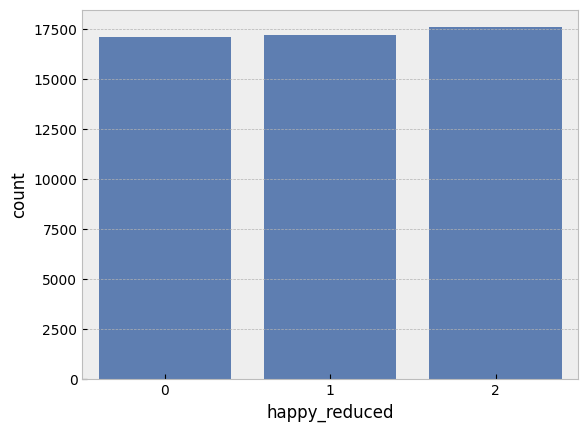

In [52]:
sns.barplot(aux_data["happy_reduced"].value_counts(), color=color);

In [53]:
np.sort(aux_data['happy_reduced'].unique())

array([0, 1, 2])

In [54]:
from sklearn.preprocessing import MinMaxScaler
minmax_X = MinMaxScaler()
minmax_Y = MinMaxScaler()
continuous_cols = [col for col in aux_data.columns if "_desc" not in col and "happy" not in col and "cntry" not in col]
cntry_cols = [col for col in aux_data.columns if "cntry" in col]
aux_data[continuous_cols] = minmax_X.fit_transform(aux_data[continuous_cols])
aux_data["happy_reduced"] = minmax_Y.fit_transform(aux_data["happy_reduced"].values[:, np.newaxis])

In [55]:
X = aux_data[continuous_cols + cntry_cols]
y = aux_data["happy_reduced"].values[:, np.newaxis]

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model 

In [57]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, accuracy_score

model = xgb.XGBRegressor(
    booster="gbtree",
    n_jobs=4,
    random_state=42,
    verbosity=0,
)

# Fit the classifier to the training data
model.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.19463208124920306


## Post-processing

In [58]:
yy_pred = np.round(minmax_Y.inverse_transform(y_pred[:, np.newaxis]))
yy_test = minmax_Y.inverse_transform(y_test)

In [59]:
accuracy_score(yy_pred, yy_test) * 100

69.27298988926336

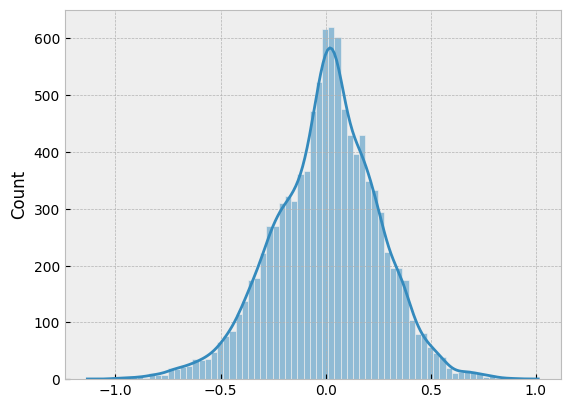

In [60]:
import seaborn as sns
sns.histplot(y_pred - y_test.squeeze(), kde=True);

In [61]:
%s/^[A-Z].*//g
%s/\(\d\) \t/\1: "/g
%s/^\*.*//g
%s/Not applicable\*/-1/g
%s/".*/\0",/g
%s/".*\*/"\*/g
%s/^[a-z].*/}, "\0": {/g
%s/^\n//g
%s/,$\n}/}/g
%s/^\(\d\+\)/"\1"/g

UsageError: Line magic function `%s/^[A-Z].*//g` not found.


1. KMeans vs Happiness classification
2. ~Add country and gender with one hot encoding~
3. Use GridSreachCV for cross-validation score